<a href="https://colab.research.google.com/github/Jonny55921/CSCI-167/blob/main/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [6]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-nml99qdf
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-nml99qdf
  Resolved https://github.com/greydanus/mnist1d to commit 68cb6b2d1d3a956cc2e9035e5a9860b66e33d642
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post15-py3-none-any.whl size=14561 sha256=648bff5600ee2339d383cb3c016ab01db59e796405da59d840ce8e03ae5e6bad
  Stored in directory: /tmp/pip-ephem-wheel-cache-fvgmqfx7/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [7]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [8]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [9]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = nn.Sequential(
    nn.Linear(D_i, D_k),   # First hidden layer
    nn.ReLU(),             # Activation after first hidden layer
    nn.Linear(D_k, D_k),   # Second hidden layer
    nn.ReLU(),             # Activation after second hidden layer
    nn.Linear(D_k, D_o)    # Output layer
)


def weights_init(layer_in):
  # TO DO:
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  print("Initializing layer")


# Call the function you just defined
model.apply(weights_init)


Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [10]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 1.590108, train error 61.17,  test loss 1.688385, test error 65.70
Epoch     1, train loss 1.356155, train error 51.03,  test loss 1.520759, test error 61.30
Epoch     2, train loss 1.195764, train error 44.62,  test loss 1.438411, test error 57.00
Epoch     3, train loss 1.001726, train error 34.80,  test loss 1.245031, test error 47.50
Epoch     4, train loss 0.919992, train error 33.32,  test loss 1.218401, test error 46.40
Epoch     5, train loss 0.816977, train error 29.50,  test loss 1.176557, test error 44.40
Epoch     6, train loss 0.724956, train error 25.68,  test loss 1.135587, test error 42.50
Epoch     7, train loss 0.665058, train error 22.07,  test loss 1.137948, test error 43.00
Epoch     8, train loss 0.586014, train error 19.25,  test loss 1.143566, test error 42.40
Epoch     9, train loss 0.536076, train error 17.57,  test loss 1.1

In [15]:
# MY ATTEMPT AT MAKING MORE EFFICIENT... CLOSE BUT DIDN'T MAKE MORE EFFICIENT

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

# Parameters
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(D_i, D_k)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(D_k, D_k)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(D_k, D_o)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
model = SimpleModel()

# Choose cross-entropy loss function
loss_function = nn.CrossEntropyLoss()

# Use SGD optimizer with original learning rate
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Load your data
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test = torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# DataLoader with original batch size
data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True)

# Training parameters
n_epoch = 50
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
    model.train()  # Set model to training mode
    for i, batch in enumerate(data_loader):
        x_batch, y_batch = batch
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        pred_train = model(x_train)
        pred_test = model(x_test)
        _, predicted_train_class = torch.max(pred_train.data, 1)
        _, predicted_test_class = torch.max(pred_test.data, 1)
        errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
        errors_test[epoch] = 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
        losses_train[epoch] = loss_function(pred_train, y_train).item()
        losses_test[epoch] = loss_function(pred_test, y_test).item()

    print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f}, test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

    # Step the learning rate scheduler
    scheduler.step()


Epoch     0, train loss 1.775153, train error 71.38, test loss 1.774840, test error 73.40
Epoch     1, train loss 1.581490, train error 62.47, test loss 1.624370, test error 67.00
Epoch     2, train loss 1.410062, train error 56.42, test loss 1.442977, test error 59.00
Epoch     3, train loss 1.287085, train error 48.72, test loss 1.357993, test error 53.90
Epoch     4, train loss 1.257904, train error 50.12, test loss 1.365630, test error 55.50
Epoch     5, train loss 1.131184, train error 41.72, test loss 1.244650, test error 48.80
Epoch     6, train loss 1.079614, train error 40.62, test loss 1.206061, test error 47.30
Epoch     7, train loss 0.984594, train error 36.97, test loss 1.174948, test error 45.40
Epoch     8, train loss 0.941142, train error 35.50, test loss 1.162970, test error 44.90
Epoch     9, train loss 0.875063, train error 32.90, test loss 1.146149, test error 45.20
Epoch    10, train loss 0.758737, train error 27.50, test loss 1.046434, test error 40.40
Epoch    1

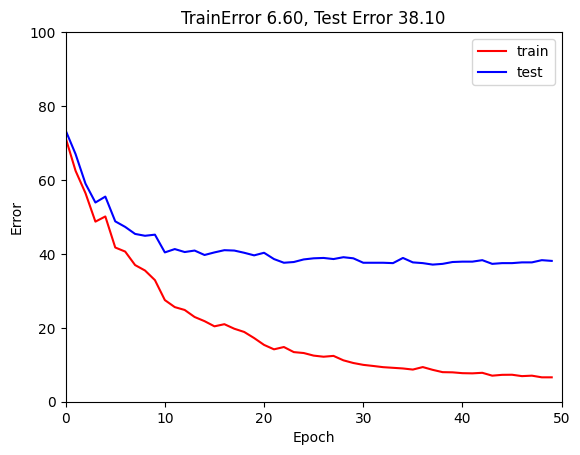

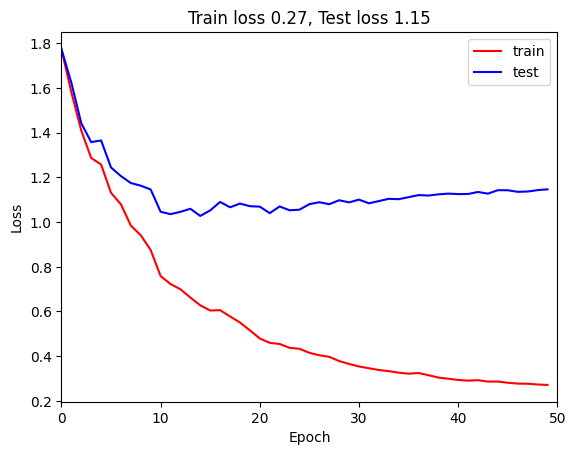

In [16]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

Adjusting hyperparamters manually may take up some time especially if you have very many and are doing one at a time. I believe if you determine what direction you should be heading with a hyperparameter you may be able to automate it to find the optimal value. You will also have to adjust at small increments so you know how the model is affected as a whole.

To determine if the final result is a good estimate of the true test performance you have to consider how well it does with both a test set and training set. Given that the test set performs well that is usually a good indicator but you also have to compare training and test errors to ensure there is no overfitting. However, usually the performance of the test set and training set can be a good indicator if the final result is a good estimate of the true test performance.